In [ ]:
#versão da Linguagem Python
from platform import python_version
print('Versão da linguagem Python usada no ambiente virtual desse projeto:', python_version())

Versão da linguagem Python usada no ambiente virtual desse projeto: 3.12.3


In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada
# Célula para instalação (executar uma vez)
pip install pmdarima

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

### 1.1 Importando as bibliotecas que serão usadas

In [2]:
import sys  # Módulo para interagir com o interpretador Python
import os   # Módulo para operações do sistema operacional

# os.getcwd() - obtém o diretório atual (Current Working Directory)
# os.path.join() - junta partes do caminho de forma segura
# "../.." - sobe dois níveis na hierarquia de diretórios
# os.path.abspath() - converte o caminho relativo em absoluto
projeto_dir = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Adiciona o caminho do projeto ao sys.path
# sys.path é onde o Python procura módulos para importar
sys.path.append(projeto_dir)

# Importando as Bibliotecas/Pacotes
# Evitar mensagens de erros
import warnings 
warnings.filterwarnings('ignore')

# Manipulação de dados
import pandas as pd
import numpy as np

#visualização
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#modelos
from math import ceil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import pickle
import holidays
br_holidays = holidays.Brazil()

# Configurar estilo dos gráficos
sns.set(style="whitegrid")

# Importa tudo (*) do módulo limpeza_dados
from src.limpeza_dados import*

### 1.2 Carregando o dataset

In [3]:
df = pd.read_csv('/home/manuel-finda/Documentos/HUB de IA/projetos/Previsao_demanda_nathor/data/DATASET_COMPLETO.csv',delimiter=';',parse_dates=True, index_col=0)
print(df.head())
df.shape

             LINHA  QUANT_FATURADA  QUANT_PENDENTE  QUANT_PEDIDA      MES  \
DATA                                                                        
2022-11-01  ARO 12            1660               0          1660  2022-11   
2022-11-01  ARO 24               0               0             0      NaN   
2022-11-01  ARO 16              72               0            72  2022-11   
2022-11-01  ARO 26               0               0             0      NaN   
2022-11-01  ARO 14              90               0            90  2022-11   

            QUANTIDADE  QUANTIDADE_PRODUZIDA  SALDO  
DATA                                                 
2022-11-01           0                  3000  14566  
2022-11-01           0                     0      2  
2022-11-01           0                    98   2666  
2022-11-01           0                     0    232  
2022-11-01           0                    15    577  


(6705, 8)

In [4]:
# Carregar o dataset de planejamento futuro
df_planejamento = pd.read_csv('/home/manuel-finda/Documentos/HUB de IA/projetos/Previsao_demanda_nathor/data/PLANEJAMENTO_Agrupado_por_linha_limpo.csv', delimiter=';',parse_dates=True, index_col=0)
print(df_planejamento.head())
df_planejamento.shape

             LINHA  QUANTIDADE
DATA                          
2024-11-15  ARO 12           0
2024-11-15  ARO 14           0
2024-11-15  ARO 16           0
2024-11-15  ARO 20           0
2024-11-15  ARO 24           0


(3708, 2)

In [5]:
df_planejamento.index

DatetimeIndex(['2024-11-15', '2024-11-15', '2024-11-15', '2024-11-15',
               '2024-11-15', '2024-11-15', '2024-11-15', '2024-11-15',
               '2024-11-15', '2024-11-16',
               ...
               '2025-12-30', '2025-12-31', '2025-12-31', '2025-12-31',
               '2025-12-31', '2025-12-31', '2025-12-31', '2025-12-31',
               '2025-12-31', '2025-12-31'],
              dtype='datetime64[ns]', name='DATA', length=3708, freq=None)

In [6]:
df.index

DatetimeIndex(['2022-11-01', '2022-11-01', '2022-11-01', '2022-11-01',
               '2022-11-01', '2022-11-01', '2022-11-01', '2022-11-01',
               '2022-11-01', '2022-11-02',
               ...
               '2024-11-13', '2024-11-14', '2024-11-14', '2024-11-14',
               '2024-11-14', '2024-11-14', '2024-11-14', '2024-11-14',
               '2024-11-14', '2024-11-14'],
              dtype='datetime64[ns]', name='DATA', length=6705, freq=None)

### 1.3 Já iremos pivotar o dataset, deixando cada coluna como uma Linha de produtos para facilitar as análises

In [7]:
# Salvar o DataFrame original antes do pivoteamento
df_original = df.copy()
df_planejamento_original = df_planejamento.copy()

In [8]:
df = df.pivot(columns='LINHA',values='QUANT_FATURADA')
df.index = pd.to_datetime(df.index)

# colocaremos 0 em todos os Nan
df.fillna(0,inplace=True)
df

LINHA,ARO 12,ARO 14,ARO 16,ARO 20,ARO 24,ARO 26,BALANCE,CAPACETE,TRICICLO
DATA,,,,,,,,,
2022-11-01,1660,90,72,111,0,0,0,254,90
2022-11-02,30,4,0,0,0,0,0,0,6
2022-11-03,1257,109,219,517,0,6,730,56,195
2022-11-04,345,27,51,32,0,5,0,0,120
2022-11-05,38,0,3,0,0,0,0,0,25
...,...,...,...,...,...,...,...,...,...
2024-11-10,0,0,0,0,0,0,0,0,0
2024-11-11,913,2,339,0,0,0,103,594,195
2024-11-12,331,32,217,7,0,0,77,8,168


In [9]:
df_planejamento = df_planejamento.pivot(columns='LINHA',values='QUANTIDADE')
df_planejamento.index = pd.to_datetime(df_planejamento.index)

# colocaremos 0 em todos os Nan
df_planejamento.fillna(0,inplace=True)
df_planejamento

LINHA,ARO 12,ARO 14,ARO 16,ARO 20,ARO 24,ARO 26,BALANCE,CAPACETE,TRICICLO
DATA,,,,,,,,,
2024-11-15,0,0,0,0,0,0,5,0,0
2024-11-16,0,0,0,0,0,0,0,0,0
2024-11-17,0,0,0,0,0,0,0,0,0
2024-11-18,3000,100,400,200,0,0,605,60,650
2024-11-19,3000,100,420,200,0,0,605,60,650
...,...,...,...,...,...,...,...,...,...
2025-12-27,0,0,0,0,0,0,0,0,0
2025-12-28,0,0,0,0,0,0,0,0,0
2025-12-29,0,0,0,0,0,0,0,0,0


Dataset está sempre considerando o faturamento no dia primeiro de cada mês de cada ano.

### 1.4 Criando uma nova coluna no dataset que indica o total de cada Dia, considerando todas a linhas

In [10]:
df['QUANT_FATURADA'] = df.sum(axis=1)
df

LINHA,ARO 12,ARO 14,ARO 16,ARO 20,ARO 24,ARO 26,BALANCE,CAPACETE,TRICICLO,QUANT_FATURADA
DATA,,,,,,,,,,
2022-11-01,1660,90,72,111,0,0,0,254,90,2277
2022-11-02,30,4,0,0,0,0,0,0,6,40
2022-11-03,1257,109,219,517,0,6,730,56,195,3089
2022-11-04,345,27,51,32,0,5,0,0,120,580
2022-11-05,38,0,3,0,0,0,0,0,25,66
...,...,...,...,...,...,...,...,...,...,...
2024-11-10,0,0,0,0,0,0,0,0,0,0
2024-11-11,913,2,339,0,0,0,103,594,195,2146
2024-11-12,331,32,217,7,0,0,77,8,168,840


### 1.5 Analisando o tipo das colunas do dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745 entries, 2022-11-01 to 2024-11-14
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ARO 12          745 non-null    int64
 1   ARO 14          745 non-null    int64
 2   ARO 16          745 non-null    int64
 3   ARO 20          745 non-null    int64
 4   ARO 24          745 non-null    int64
 5   ARO 26          745 non-null    int64
 6   BALANCE         745 non-null    int64
 7   CAPACETE        745 non-null    int64
 8   TRICICLO        745 non-null    int64
 9   QUANT_FATURADA  745 non-null    int64
dtypes: int64(10)
memory usage: 64.0 KB


todas as colunas são do tipo inteiro, como esperado

In [12]:
pd.infer_freq(df.index)

'D'

In [13]:
pd.infer_freq(df_planejamento.index)

'D'

In [14]:
df.index

DatetimeIndex(['2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
               '2022-11-05', '2022-11-06', '2022-11-07', '2022-11-08',
               '2022-11-09', '2022-11-10',
               ...
               '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08',
               '2024-11-09', '2024-11-10', '2024-11-11', '2024-11-12',
               '2024-11-13', '2024-11-14'],
              dtype='datetime64[ns]', name='DATA', length=745, freq=None)

In [15]:
df_planejamento

LINHA,ARO 12,ARO 14,ARO 16,ARO 20,ARO 24,ARO 26,BALANCE,CAPACETE,TRICICLO
DATA,,,,,,,,,
2024-11-15,0,0,0,0,0,0,5,0,0
2024-11-16,0,0,0,0,0,0,0,0,0
2024-11-17,0,0,0,0,0,0,0,0,0
2024-11-18,3000,100,400,200,0,0,605,60,650
2024-11-19,3000,100,420,200,0,0,605,60,650
...,...,...,...,...,...,...,...,...,...
2025-12-27,0,0,0,0,0,0,0,0,0
2025-12-28,0,0,0,0,0,0,0,0,0
2025-12-29,0,0,0,0,0,0,0,0,0


### 1.6. Vamos olhar também as principais métricas do dataset para avaliar se não tem nenhum valor estranho

In [16]:
df.describe()

LINHA,ARO 12,ARO 14,ARO 16,ARO 20,ARO 24,ARO 26,BALANCE,CAPACETE,TRICICLO,QUANT_FATURADA
count,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000,745.000000
mean,1564.624161,26.655034,329.034899,84.641611,0.212081,1.908725,168.398658,163.213423,309.209396,2647.897987
std,3188.733841,124.160440,614.888852,248.822640,1.080429,5.125022,353.342052,362.640916,691.462584,4453.169133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,85.000000
50%,652.000000,2.000000,121.000000,24.000000,0.000000,0.000000,15.000000,28.000000,129.000000,1313.000000
75%,1744.000000,14.000000,392.000000,76.000000,0.000000,2.000000,178.000000,175.000000,335.000000,3234.000000
max,41512.000000,2104.000000,7097.000000,4888.000000,15.000000,73.000000,3568.000000,3256.000000,9118.000000,54338.000000


Aparentemente não tem valores estranhos (negativos, por exemplo)

Como foram colocados 0 no lugar dos Nan, isso alterou as métricas de posição e para corrigir isso vamos desconsiderar os valores <=0 e olhar as principais métricas de posição

In [17]:
df[df>0].describe()

LINHA,ARO 12,ARO 14,ARO 16,ARO 20,ARO 24,ARO 26,BALANCE,CAPACETE,TRICICLO,QUANT_FATURADA
count,625.000000,437.000000,611.000000,546.000000,54.000000,287.000000,502.000000,447.000000,607.000000,643.000000
mean,1865.032000,45.441648,401.196399,115.490842,2.925926,4.954704,249.914343,272.022371,379.507414,3067.937792
std,3400.330064,159.531293,657.377645,284.517175,2.880329,7.292685,406.194887,435.559945,748.516391,4657.330402
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
25%,295.000000,3.000000,58.000000,18.000000,1.000000,2.000000,14.000000,49.000000,60.000000,492.500000
50%,900.000000,10.000000,192.000000,45.000000,2.000000,3.000000,97.500000,136.000000,184.000000,1764.000000
75%,2037.000000,27.000000,451.000000,108.000000,4.000000,5.000000,306.750000,304.500000,421.500000,3717.000000
max,41512.000000,2104.000000,7097.000000,4888.000000,15.000000,73.000000,3568.000000,3256.000000,9118.000000,54338.000000


Analisando os dados apresentados no `describe()` e entendendo que a coluna `QUANT_FATURADA` representa a soma diária das quantidades faturadas por linha de produção, aqui estão os pontos e análises que podem ser feitos para auxiliar no estudo da série temporal:


### **Compreensão Geral dos Dados**
1. **Contagem (count)**:
   - Reflete a quantidade de dias com registros de faturamento por linha.
   - Algumas linhas têm menos registros (`ARO 24` com apenas 54), indicando que podem ter pouca atividade ou registros inconsistentes.

2. **Média (mean)**:
   - `ARO 12` tem a maior média de faturamento diário (1865), deixando claro que é a linha mais produtiva.
   - Outras linhas, como `ARO 14` e `ARO 24`, têm médias bem baixas, o que sugere menor relevância ou volume de vendas.

3. **Desvio Padrão (std)**:
   - Indica a variabilidade das quantidades faturadas.
   - Linhas como `ARO 12` (3400) e `CAPACETE` (435) têm alta variabilidade, indicando períodos de picos e quedas acentuadas.

4. **Valores Máximos (max)**:
   - `ARO 12` (41512) e `QUANT_FATURADA` (54338) têm picos muito altos, sugerindo eventos excepcionais.







### 2. FUNÇÕES DE ANÁLISE E TRATAMENTO ###

In [18]:

def identificar_picos(serie, threshold=3):
    """
    Identifica picos (outliers) na série usando o método do desvio padrão.
    
    Args:
        serie: Série temporal
        threshold: Número de desvios padrão para considerar um pico
    
    Returns:
        DataFrame com variáveis dummy para os picos
    """
    media = serie.mean()
    desvio = serie.std()
    limite = media + (threshold * desvio)
    
    picos = pd.DataFrame(index=serie.index)
    picos['is_peak'] = (serie > limite).astype(int)
    
    print(f"Número de picos identificados: {picos['is_peak'].sum()}")
    return picos

def analisar_sazonalidade(serie):
    """
    Analisa padrões sazonais na série temporal.
    """
    # Médias por diferentes períodos
    medias_diarias = serie.groupby(serie.index.day).mean()
    medias_semanais = serie.groupby(serie.index.isocalendar().week).mean()
    medias_mensais = serie.groupby(serie.index.month).mean()
    
    # Visualização
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    medias_diarias.plot(ax=ax1, title='Padrão Diário')
    ax1.set_xlabel('Dia do Mês')
    
    medias_semanais.plot(ax=ax2, title='Padrão Semanal')
    ax2.set_xlabel('Semana do Ano')
    
    medias_mensais.plot(ax=ax3, title='Padrão Mensal')
    ax3.set_xlabel('Mês')
    
    plt.tight_layout()
    plt.show()
    
    return medias_diarias, medias_semanais, medias_mensais

def testar_transformacoes(serie):
    """
    Testa diferentes transformações para estabilizar a variância.
    """
    # Log transformation (usando log1p para lidar com zeros)
    log_serie = pd.Series(np.log1p(serie), index=serie.index)
    
    # Box-Cox transformation
    boxcox_serie, lambda_param = stats.boxcox(serie + 1)
    # Converter para Series do pandas
    boxcox_serie = pd.Series(boxcox_serie, index=serie.index)
    
    # Square root transformation
    sqrt_serie = pd.Series(np.sqrt(serie), index=serie.index)
    
    # Visualização
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    serie.plot(ax=ax1, title='Original')
    ax1.set_ylabel('Quantidade')
    
    log_serie.plot(ax=ax2, title='Log Transform')
    ax2.set_ylabel('Log(Quantidade)')
    
    boxcox_serie.plot(ax=ax3, title='Box-Cox Transform')
    ax3.set_ylabel('Box-Cox(Quantidade)')
    
    sqrt_serie.plot(ax=ax4, title='Square Root Transform')
    ax4.set_ylabel('Sqrt(Quantidade)')
    
    plt.tight_layout()
    plt.show()
    
    # Comparar variâncias
    variancias = {
        'Original': serie.var(),
        'Log': log_serie.var(),
        'Box-Cox': boxcox_serie.var(),
        'Square Root': sqrt_serie.var()
    }
    
    print("\nComparação de Variâncias:")
    for k, v in variancias.items():
        print(f"{k}: {v:.2f}")
    
    # Identificar transformação com menor variância
    melhor_transf = min(variancias.items(), key=lambda x: x[1])[0]
    print(f"\nMelhor transformação: {melhor_transf}")
    
    # Retornar a série com a melhor transformação
    if melhor_transf == 'Log':
        return log_serie
    elif melhor_transf == 'Box-Cox':
        return boxcox_serie
    elif melhor_transf == 'Square Root':
        return sqrt_serie
    else:
        return serie




### 3. ANÁLISE DA SÉRIE ###


Analisando linha: ARO 12

Estatísticas descritivas:
count      745.000000
mean      1564.624161
std       3188.733841
min          0.000000
25%         42.000000
50%        652.000000
75%       1744.000000
max      41512.000000
Name: ARO 12, dtype: float64


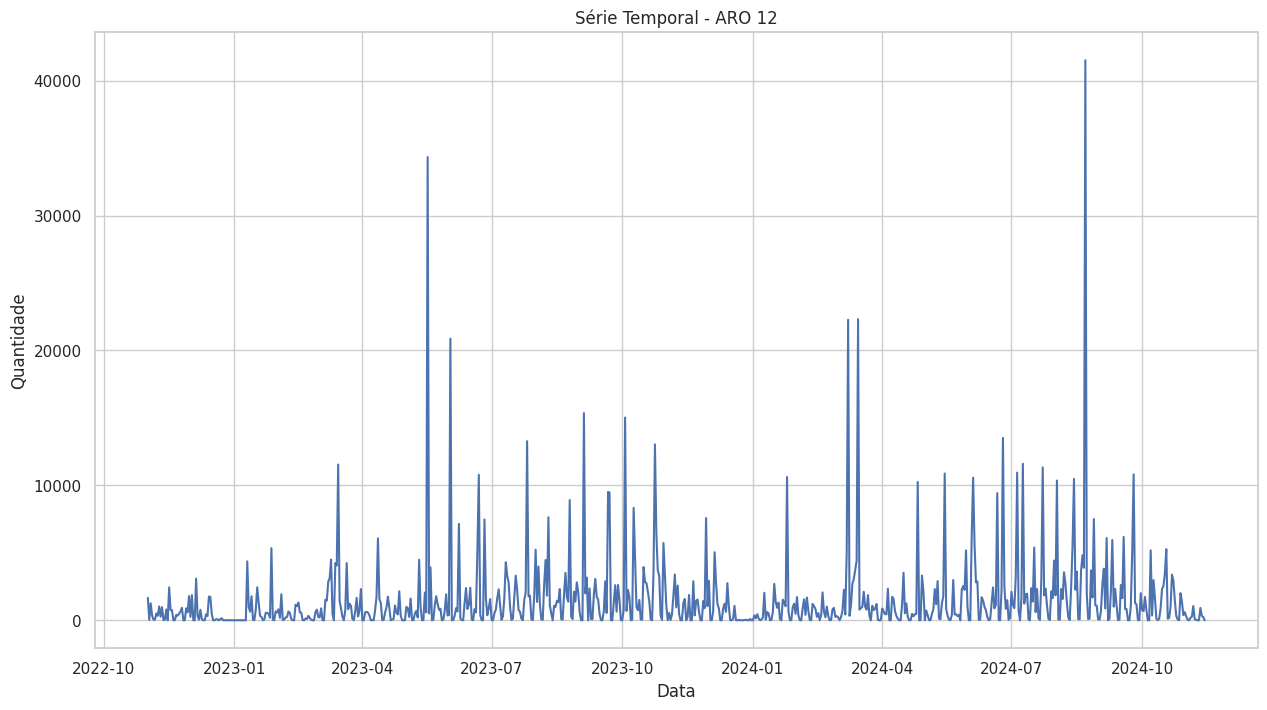

In [19]:

# Selecionar linha específica
linha = 'ARO 12'
serie = df[linha]
planejamento_serie = df_planejamento[linha]

print(f"\nAnalisando linha: {linha}")
print("\nEstatísticas descritivas:")
print(serie.describe())

# Visualização inicial
plt.figure(figsize=(15, 8))
plt.plot(serie.index, serie.values)
plt.title(f'Série Temporal - {linha}')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.grid(True)
plt.show()



In [20]:

def testar_estacionariedade(serie):
    """
    Testa a estacionariedade da série usando o teste ADF.
    """
    resultado = adfuller(serie)
    print(f'Estatística ADF: {resultado[0]}')
    print(f'p-valor: {resultado[1]}')
    print(f'Valores Críticos: {resultado[4]}')
    if resultado[1] > 0.05:
        print("A série NÃO é estacionária.")
    else:
        print("A série é estacionária.")

testar_estacionariedade(serie)

Estatística ADF: -7.049911037634789
p-valor: 5.561001445964092e-10
Valores Críticos: {'1%': -3.4392539652094154, '5%': -2.86546960465041, '10%': -2.5688625527782327}
A série é estacionária.


### 4. TRATAMENTO E MODELAGEM ###


Identificando picos na série...
Número de picos identificados: 13

Analisando padrões sazonais...


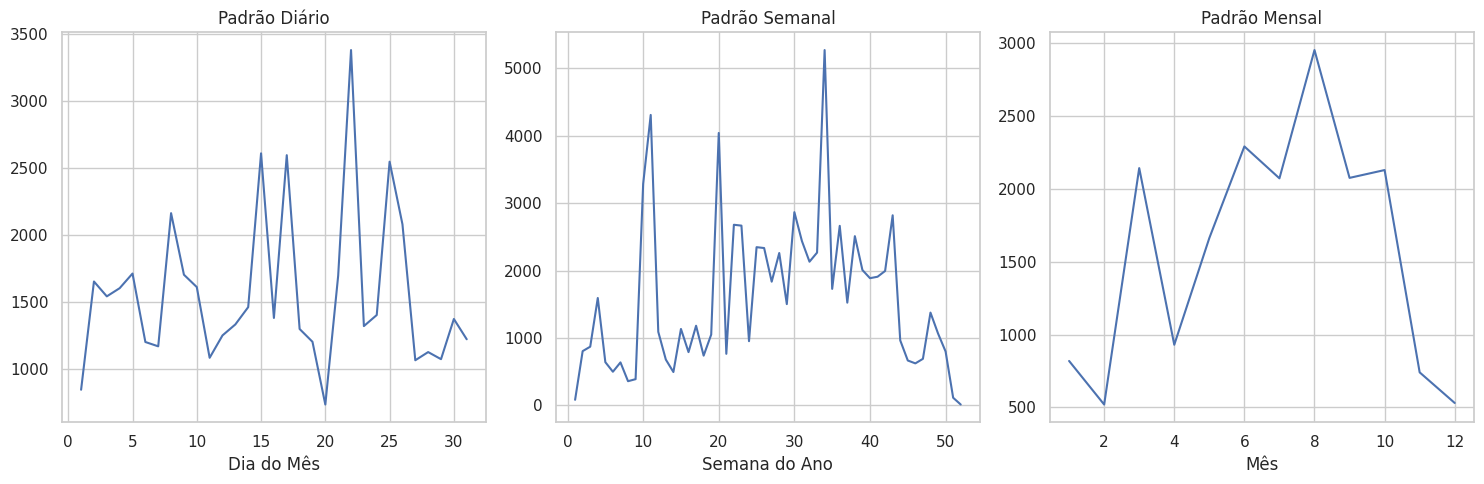


Testando transformações...


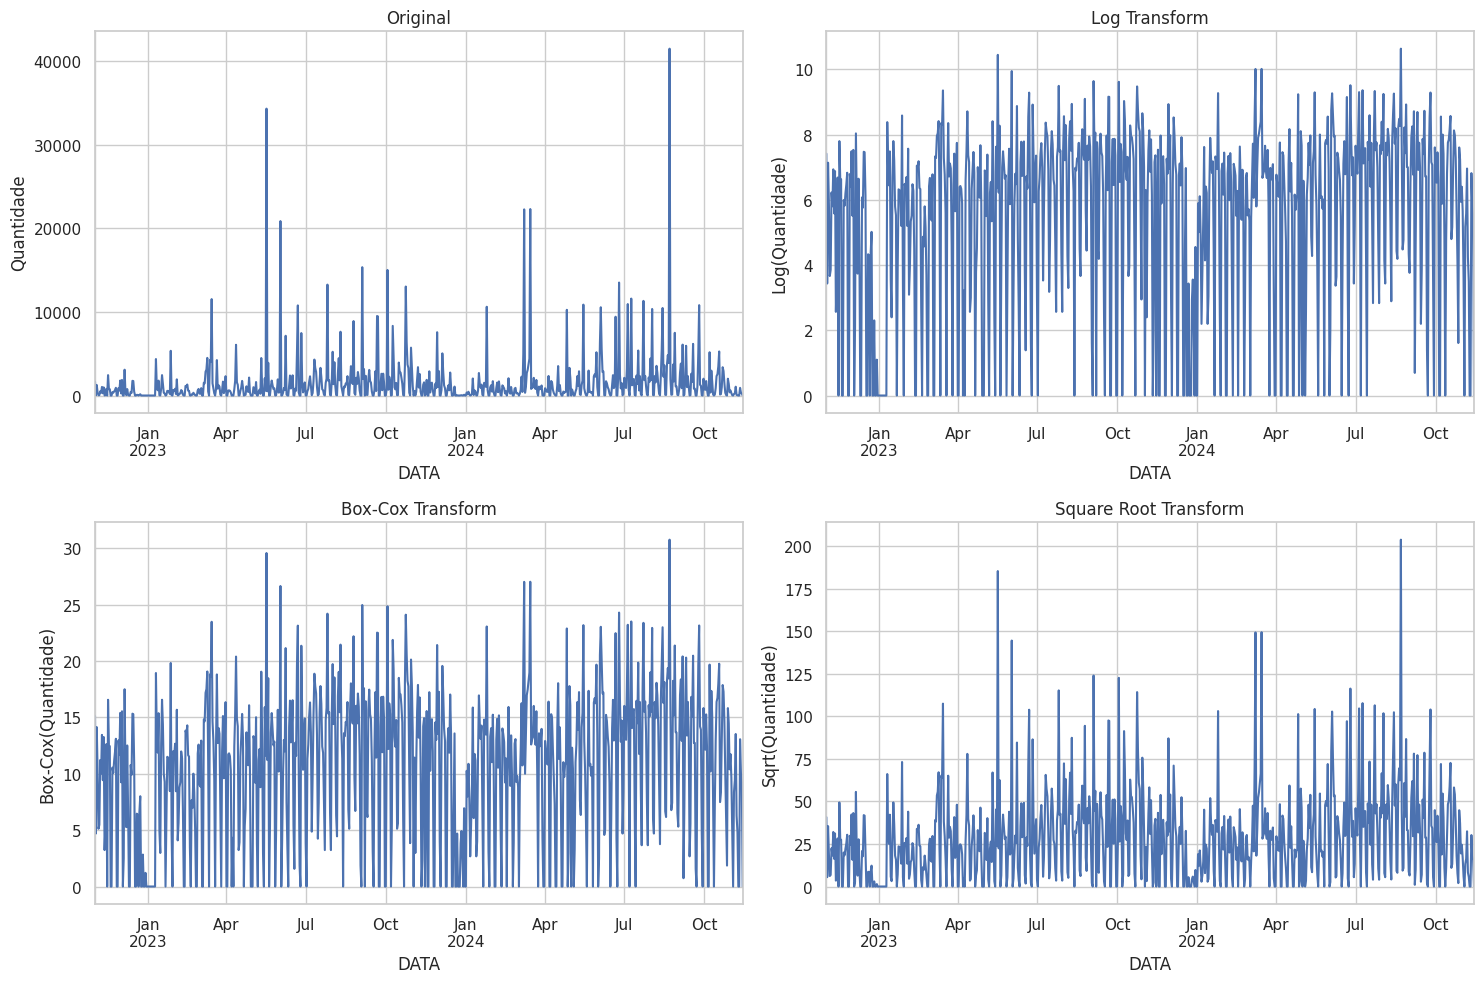


Comparação de Variâncias:
Original: 10168023.51
Log: 8.24
Box-Cox: 43.74
Square Root: 732.08

Melhor transformação: Log


In [21]:

# Identificar picos
print("\nIdentificando picos na série...")
picos = identificar_picos(serie)

# Analisar sazonalidade
print("\nAnalisando padrões sazonais...")
padroes = analisar_sazonalidade(serie)

# Testar transformações e obter a série transformada
print("\nTestando transformações...")
serie_transformada = testar_transformacoes(serie)





In [22]:

testar_estacionariedade(serie_transformada)

Estatística ADF: -4.068547824351676
p-valor: 0.001091187219348168
Valores Críticos: {'1%': -3.4394144152232995, '5%': -2.8655403100177566, '10%': -2.5689002207655443}
A série é estacionária.


In [23]:


black_friday = (serie.index.month == 11) & (serie.index.day == 25)


#  criar variáveis sazonais explícitas
dados_sazonais = pd.DataFrame({
    'dia_semana':serie.index.weekday,
    'fim_semana':(serie.index.weekday >= 5).astype(int),
    'dia_mes': serie.index.day,
    'mes': serie.index.month,
    'semana_ano': serie.index.isocalendar().week,
    'fim_mes': (serie.index.day >= 25).astype(int),  # Indicador para fim de mês
    'meio_ano': serie.index.month.isin([5,6,7]).astype(int),  # Indicador para meio do ano
    'dias_picos': serie.index.day.isin([3,5,8,15,22,25]).astype(int),  # dias de pico
    'alta_temporada': serie.index.month.isin([3,6,8,10]).astype(int),
    'black_friday':black_friday.astype(int),
    'feriado': serie.index.isin(br_holidays).astype(int),  
    'dia_util': (serie.index.weekday<5).astype(int),
    'primeira_quinzena':(serie.index.day<=15).astype(int),
    'trimestre':serie.index.quarter,
    'inicio_ano':(serie.index.month<=3).astype(int),
    'fim_ano':(serie.index.month>=10).astype(int),
    'QUANT_PLANEJADA': df_original.loc[df_original['LINHA'] == linha, 'QUANTIDADE'].values  # Filtrar QUANT_PLANEJADA 
})



In [24]:
dados_sazonais.head()

,dia_semana,fim_semana,dia_mes,mes,semana_ano,fim_mes,meio_ano,dias_picos,alta_temporada,black_friday,feriado,dia_util,primeira_quinzena,trimestre,inicio_ano,fim_ano,QUANT_PLANEJADA
DATA,,,,,,,,,,,,,,,,,
2022-11-01,1,0,1,11,44,0,0,0,0,0,0,1,1,4,0,1,0
2022-11-02,2,0,2,11,44,0,0,0,0,0,0,1,1,4,0,1,0
2022-11-03,3,0,3,11,44,0,0,1,0,0,0,1,1,4,0,1,0
2022-11-04,4,0,4,11,44,0,0,0,0,0,0,1,1,4,0,1,0
2022-11-05,5,1,5,11,44,0,0,1,0,0,0,0,1,4,0,1,0


In [25]:
dados_sazonais.dtypes

dia_semana            int32
fim_semana            int64
dia_mes               int32
mes                   int32
semana_ano           UInt32
fim_mes               int64
meio_ano              int64
dias_picos            int64
alta_temporada        int64
black_friday          int64
feriado               int64
dia_util              int64
primeira_quinzena     int64
trimestre             int32
inicio_ano            int64
fim_ano               int64
QUANT_PLANEJADA       int64
dtype: object

In [26]:
# Converter dados para formato numérico
dados_sazonais = dados_sazonais.astype(int)
dados_sazonais.dtypes

dia_semana           int64
fim_semana           int64
dia_mes              int64
mes                  int64
semana_ano           int64
fim_mes              int64
meio_ano             int64
dias_picos           int64
alta_temporada       int64
black_friday         int64
feriado              int64
dia_util             int64
primeira_quinzena    int64
trimestre            int64
inicio_ano           int64
fim_ano              int64
QUANT_PLANEJADA      int64
dtype: object

### 5. MODELAGEM COM COMPONENTES ###

In [50]:

print("\nPreparando dados para modelagem...")


# Separar treino e teste
split_point = int(len(serie) * 0.8)
train = serie_transformada[:split_point]
test = serie_transformada[split_point:]

# Separar dados sazonais em treino e teste
dados_sazonais_train = dados_sazonais[:split_point]
dados_sazonais_test = dados_sazonais[split_point:]

# Separar picos para treino e teste
picos_train = picos[:split_point]
picos_test = picos[split_point:]

print("Shapes dos dados:")
print(f"Train: {train.shape}")
print(f"Dados sazonais train: {dados_sazonais_train.shape}")
print(f"Picos train: {picos_train.shape}")




Preparando dados para modelagem...
Shapes dos dados:
Train: (596,)
Dados sazonais train: (596, 17)
Picos train: (596, 1)


In [28]:
dados_sazonais_test.head()

,dia_semana,fim_semana,dia_mes,mes,semana_ano,fim_mes,meio_ano,dias_picos,alta_temporada,black_friday,feriado,dia_util,primeira_quinzena,trimestre,inicio_ano,fim_ano,QUANT_PLANEJADA
DATA,,,,,,,,,,,,,,,,,
2023-11-08,2,0,8,11,45,0,0,1,0,0,0,1,1,4,0,1,3000
2023-11-09,3,0,9,11,45,0,0,0,0,0,0,1,1,4,0,1,3000
2023-11-10,4,0,10,11,45,0,0,0,0,0,0,1,1,4,0,1,3000
2023-11-11,5,1,11,11,45,0,0,0,0,0,0,0,1,4,0,1,2000
2023-11-12,6,1,12,11,45,0,0,0,0,0,0,0,1,4,0,1,0


In [30]:
# Encontrar melhores parâmetros
print("\nBuscando melhores parâmetros...")
model_auto = auto_arima(
    train,
    exog=dados_sazonais,
    seasonal=True,
    m=28,  # Sazonalidade mensal
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    D=1,  # Diferenciação sazonal
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)




Buscando melhores parâmetros...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[28] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(0,0,0)(0,1,0)[28] intercept   : AIC=1684.923, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[28] intercept   : AIC=1557.788, Time=1.00 sec
 ARIMA(0,0,1)(0,1,1)[28] intercept   : AIC=inf, Time=4.00 sec
 ARIMA(0,0,0)(0,1,0)[28]             : AIC=1683.591, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[28] intercept   : AIC=1651.287, Time=0.16 sec
 ARIMA(1,0,0)(2,1,0)[28] intercept   : AIC=1522.239, Time=3.09 sec
 ARIMA(1,0,0)(2,1,1)[28] intercept   : AIC=inf, Time=14.07 sec
 ARIMA(1,0,0)(1,1,1)[28] intercept   : AIC=inf, Time=4.61 sec
 ARIMA(0,0,0)(2,1,0)[28] intercept   : AIC=1545.416, Time=2.89 sec
 ARIMA(2,0,0)(2,1,0)[28] intercept   : AIC=1503.344, Time=3.94 sec
 ARIMA(2,0,0)(1,1,0)[28] intercept   : AIC=1542.643, Time=1.47 sec
 ARIMA(2,0,0)(2,1,1)[28] intercept   : AIC=inf, Time=15.93 sec
 ARIMA(2,0,0)(1,1,1)[28] intercept   : AIC=inf, Time=4.81 sec
 ARIMA(3,0,0)(

In [49]:
# Verificar tipos de dados
print("Tipos de dados:")
print("Train dtype:", train.dtype)
print("Dados sazonais dtype:", dados_sazonais_train.dtypes)

Tipos de dados:
Train dtype: float64
Dados sazonais dtype: dia_semana           int64
fim_semana           int64
dia_mes              int64
mes                  int64
semana_ano           int64
fim_mes              int64
meio_ano             int64
dias_picos           int64
alta_temporada       int64
black_friday         int64
feriado              int64
dia_util             int64
primeira_quinzena    int64
trimestre            int64
inicio_ano           int64
fim_ano              int64
QUANT_PLANEJADA      int64
dtype: object


In [51]:
# Converter dados para formato numérico
dados_sazonais_train = dados_sazonais_train.astype(int)
dados_sazonais_test = dados_sazonais_test.astype(int)

In [52]:
# Verificar tipos de dados
print("Tipos de dados:")
print("Train dtype:", train.dtype)
print("Dados sazonais dtype:", dados_sazonais_train.dtypes)

Tipos de dados:
Train dtype: float64
Dados sazonais dtype: dia_semana           int64
fim_semana           int64
dia_mes              int64
mes                  int64
semana_ano           int64
fim_mes              int64
meio_ano             int64
dias_picos           int64
alta_temporada       int64
black_friday         int64
feriado              int64
dia_util             int64
primeira_quinzena    int64
trimestre            int64
inicio_ano           int64
fim_ano              int64
QUANT_PLANEJADA      int64
dtype: object


In [53]:
# Treinar modelo com todas as variáveis exógenas
order = (2, 0, 2)
seasonal_order=(2, 1, [0], 28)

modelo = SARIMAX(
    train,
    exog=dados_sazonais_train,  # Usar dados sazonais no treino
    order=order,
    seasonal_order=seasonal_order
)
resultado = modelo.fit()

/home/manuel-finda/Documentos/HUB de IA/projetos/Previsao_demanda_nathor/venv_nathor/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/manuel-finda/Documentos/HUB de IA/projetos/Previsao_demanda_nathor/venv_nathor/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05015D+00    |proj g|=  2.74584D+01


 This problem is unconstrained.



At iterate    5    f=  2.04600D+00    |proj g|=  3.33672D+00

At iterate   10    f=  2.04322D+00    |proj g|=  5.47943D+00

At iterate   15    f=  2.04290D+00    |proj g|=  1.85666D+00

At iterate   20    f=  2.03540D+00    |proj g|=  1.61599D+01

At iterate   25    f=  2.02754D+00    |proj g|=  6.76193D-01

At iterate   30    f=  2.01893D+00    |proj g|=  1.17883D+01

At iterate   35    f=  1.99568D+00    |proj g|=  1.69944D-01

At iterate   40    f=  1.99561D+00    |proj g|=  1.23133D+00

At iterate   45    f=  1.99418D+00    |proj g|=  4.14285D+00

At iterate   50    f=  1.99397D+00    |proj g|=  1.65223D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/manuel-finda/Documentos/HUB de IA/projetos/Previsao_demanda_nathor/venv_nathor/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
# Fazer previsões no conjunto de teste
previsoes_teste = resultado.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=dados_sazonais_test  # Usar dados sazonais no teste
)


# Reverter transformação
previsoes_teste_original = np.expm1(previsoes_teste)
test_original = np.expm1(test)





In [55]:
# Calcular métricas ajustadas
def calcular_metricas(y_true, y_pred):
    """
    Calcula métricas de erro com tratamento para valores zero e outliers
    """
    # Remover pares onde y_true é zero
    mask = y_true != 0
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    # Calcular MAE e RMSE normais
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calcular MAPE evitando divisão por zero
    mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100
    
    # Calcular R² ajustado
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    }



In [56]:
# Calcular métricas
metricas = calcular_metricas(test_original, previsoes_teste_original)

print("\nMétricas de Avaliação Ajustadas:")
print(f"Erro Médio Absoluto (MAE): {metricas['MAE']:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {metricas['RMSE']:.2f}")
print(f"Erro Percentual Médio (MAPE): {metricas['MAPE']:.2f}%")
print(f"R²: {metricas['R²']:.4f}")

# Análise adicional
print("\nAnálise dos Erros:")
print(f"Média dos valores reais: {np.mean(test_original):.2f}")
print(f"Média das previsões: {np.mean(previsoes_teste_original):.2f}")
print(f"% de valores zero nos dados reais: {(test_original == 0).mean()*100:.2f}%")


Métricas de Avaliação Ajustadas:
Erro Médio Absoluto (MAE): 4802.26
Raiz do Erro Quadrático Médio (RMSE): 10597.09
Erro Percentual Médio (MAPE): 457.36%
R²: -5.3757

Análise dos Erros:
Média dos valores reais: 2253.60
Média das previsões: 6086.20
% de valores zero nos dados reais: 8.05%


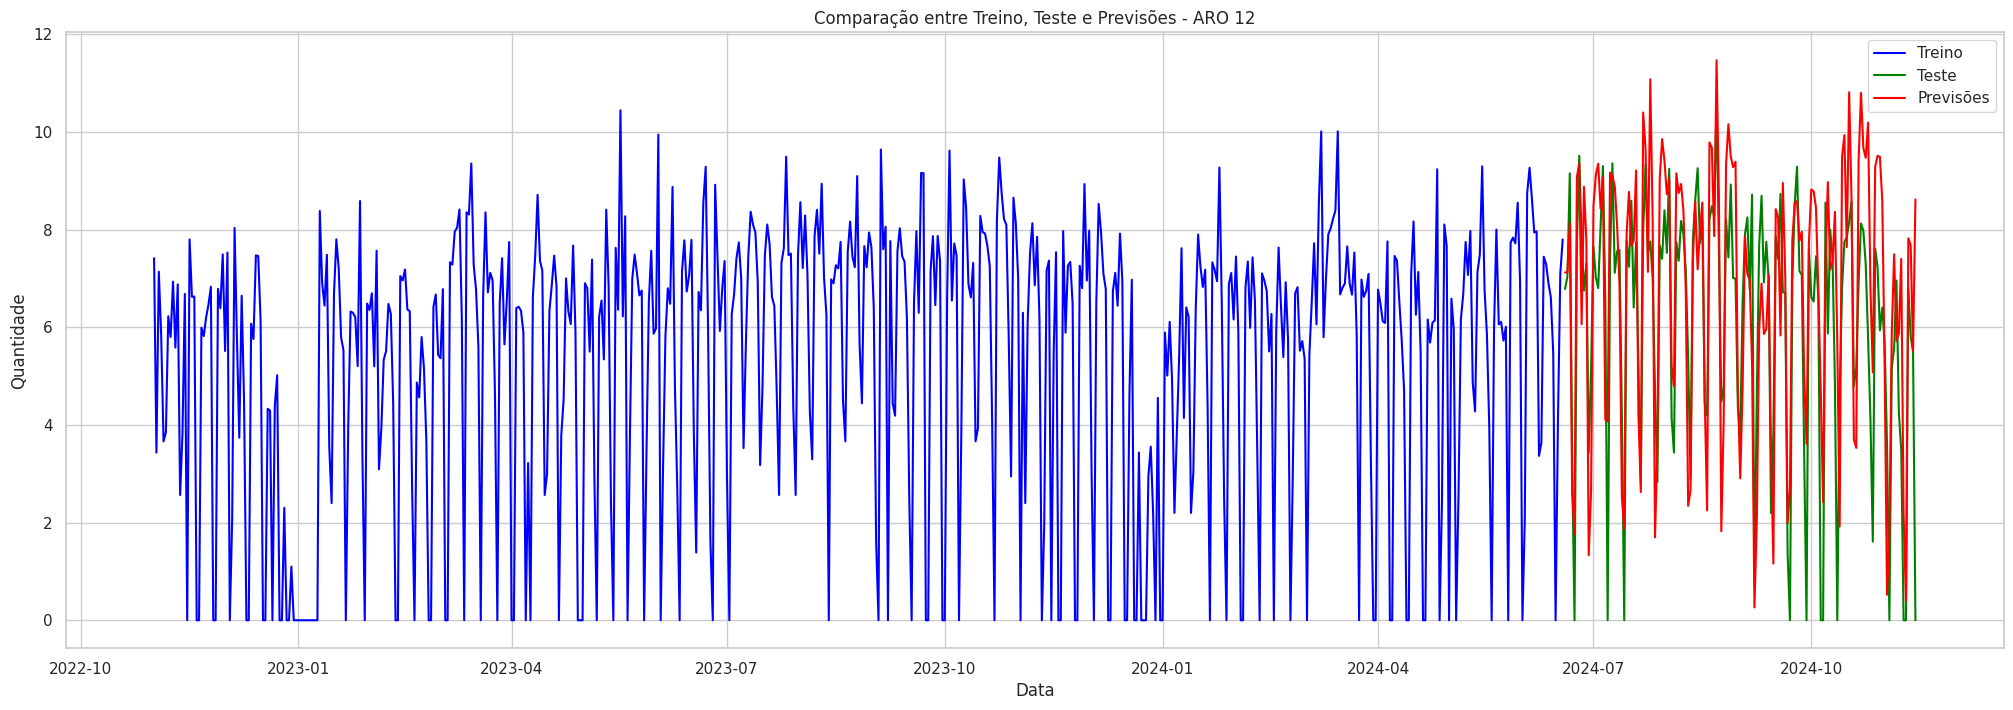

In [57]:
plt.figure(figsize=(25, 8))

# Treino
plt.plot(train.index, train, label='Treino', color='blue')

# Teste
plt.plot(test.index, test, label='Teste', color='green')

# Previsões
plt.plot(previsoes_teste.index, previsoes_teste, label='Previsões', color='red')

plt.title(f'Comparação entre Treino, Teste e Previsões - {linha}')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True)
plt.show()

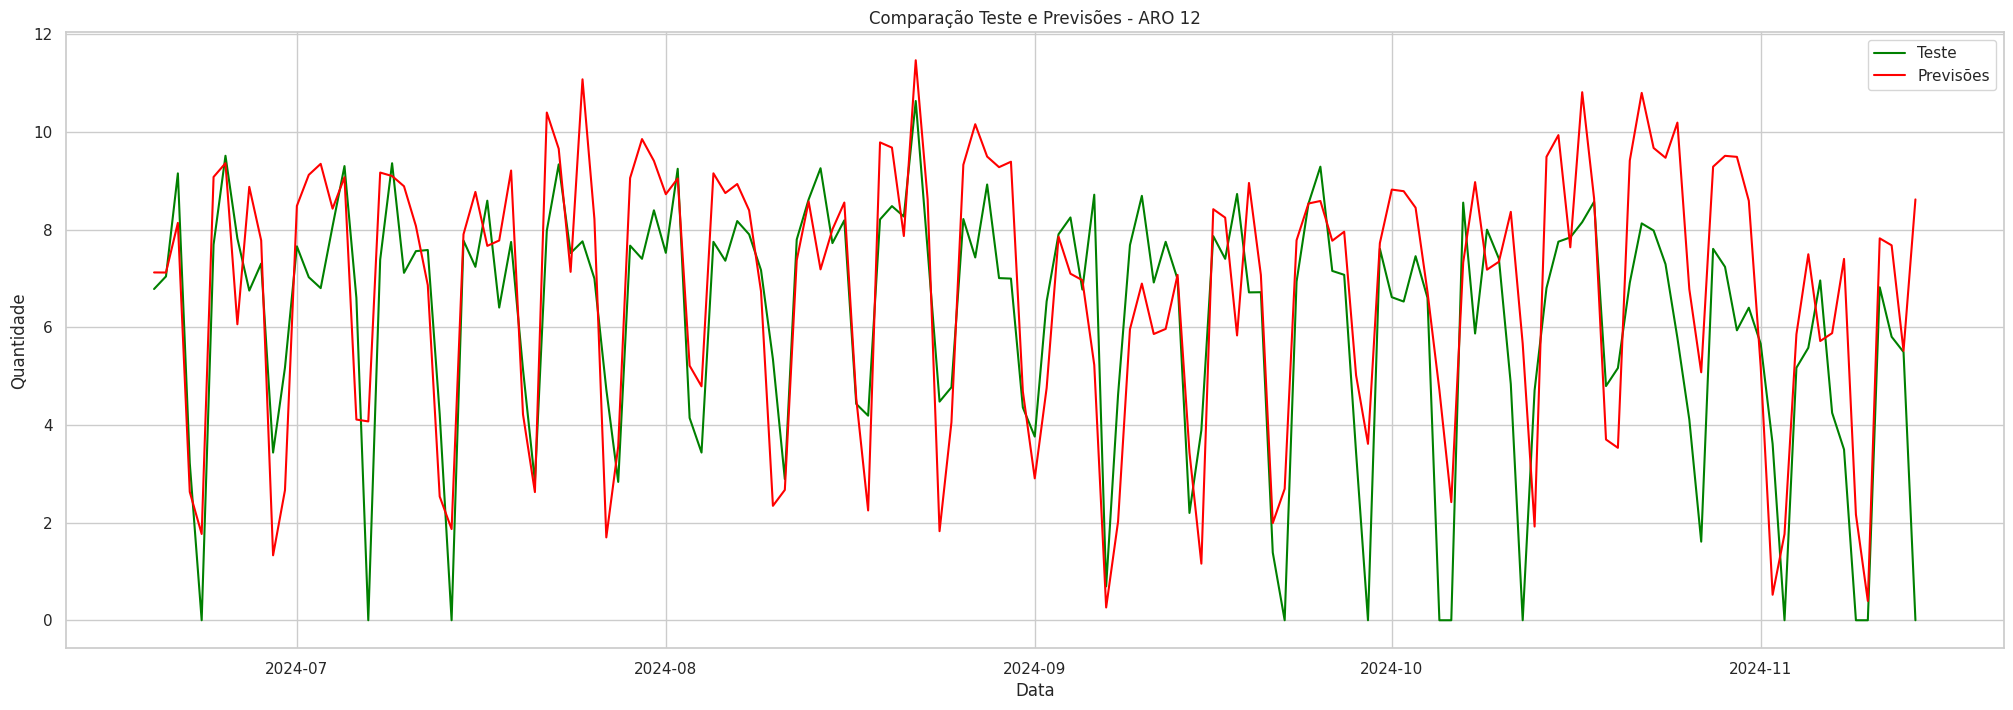

In [58]:
plt.figure(figsize=(25, 8))


# Teste
plt.plot(test.index, test, label='Teste', color='green')

# Previsões
plt.plot(previsoes_teste.index, previsoes_teste, label='Previsões', color='red')

plt.title(f'Comparação Teste e Previsões - {linha}')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Reverter transformação para visualização
def reverter_transformacao(serie, transformacao):
    """
    Reverte a transformação aplicada à série.
    """
    if transformacao == 'Log':
        return np.expm1(serie)
    elif transformacao == 'Box-Cox':
        # Aqui você precisaria do lambda usado na transformação Box-Cox
        return np.expm1(serie)  # Aproximação, pois a inversa exata depende do lambda
    elif transformacao == 'Square Root':
        return serie ** 2
    else:
        return serie



In [60]:
melhor_transf = 'Log'
serie_original = reverter_transformacao(serie_transformada, melhor_transf)
previsoes_original = reverter_transformacao(previsoes_teste, melhor_transf)

### 6. PREVISÕES FUTURAS ###

In [61]:

# Preparar dados futuros para previsão
dias_previsao = int(len(df_planejamento))
datas_futuras = pd.date_range(start=serie.index[-1] + pd.Timedelta(days=1),
                             periods=dias_previsao,
                             freq='D')

#quant_planejada = df_planejamento.loc[df_planejamento['LINHA'] == linha, 'QUANTIDADE'].values

    # Criar variáveis sazonais futuras
dados_sazonais_futuros = pd.DataFrame({
        'dia_semana': planejamento_serie.index.weekday,
        'fim_semana': (planejamento_serie.index.weekday >= 5).astype(int),
        'dia_mes': planejamento_serie.index.day,
        'mes': planejamento_serie.index.month,
        'semana_ano': planejamento_serie.index.isocalendar().week,
        'fim_mes': (planejamento_serie.index.day >= 25).astype(int),
        'meio_ano': planejamento_serie.index.month.isin([5, 6, 7]).astype(int),
        'alta_temporada': planejamento_serie.index.month.isin([3, 6, 8, 10]).astype(int),
        'black_friday': ((planejamento_serie.index.month == 11) & (planejamento_serie.index.day == 25)).astype(int),
        'feriado': planejamento_serie.index.isin(br_holidays).astype(int),
        'dias_picos': planejamento_serie.index.day.isin([3, 5, 8, 15, 22, 25]).astype(int),
        'dia_util': (planejamento_serie.index.weekday < 5).astype(int),
        'primeira_quinzena': (df_planejamento.index.day <= 15).astype(int),
        'trimestre': planejamento_serie.index.quarter,
        'inicio_ano': (planejamento_serie.index.month <= 3).astype(int),
        'fim_ano': (planejamento_serie.index.month >= 10).astype(int),
        'QUANT_PLANEJADA': df_planejamento_original.loc[df_planejamento_original['LINHA'] == linha, 'QUANTIDADE'].values  # Filtrar QUANT_PLANEJADA

        
})




In [62]:
dados_sazonais_futuros = dados_sazonais_futuros.astype(int)

In [63]:
dados_sazonais_futuros.tail()

,dia_semana,fim_semana,dia_mes,mes,semana_ano,fim_mes,meio_ano,alta_temporada,black_friday,feriado,dias_picos,dia_util,primeira_quinzena,trimestre,inicio_ano,fim_ano,QUANT_PLANEJADA
DATA,,,,,,,,,,,,,,,,,
2025-12-27,5,1,27,12,52,1,0,0,0,0,0,0,0,4,0,1,0
2025-12-28,6,1,28,12,52,1,0,0,0,0,0,0,0,4,0,1,0
2025-12-29,0,0,29,12,1,1,0,0,0,0,0,1,0,4,0,1,0
2025-12-30,1,0,30,12,1,1,0,0,0,0,0,1,0,4,0,1,0
2025-12-31,2,0,31,12,1,1,0,0,0,0,0,1,0,4,0,1,0


In [64]:
# Fazer previsões futuras
forecast = resultado.get_forecast(
    steps=dias_previsao,
    exog=dados_sazonais_futuros  # Usar dados sazonais futuros
)

# Transformar previsões de volta para escala original
forecast_mean = np.expm1(forecast.predicted_mean)
forecast_ci = np.expm1(forecast.conf_int())

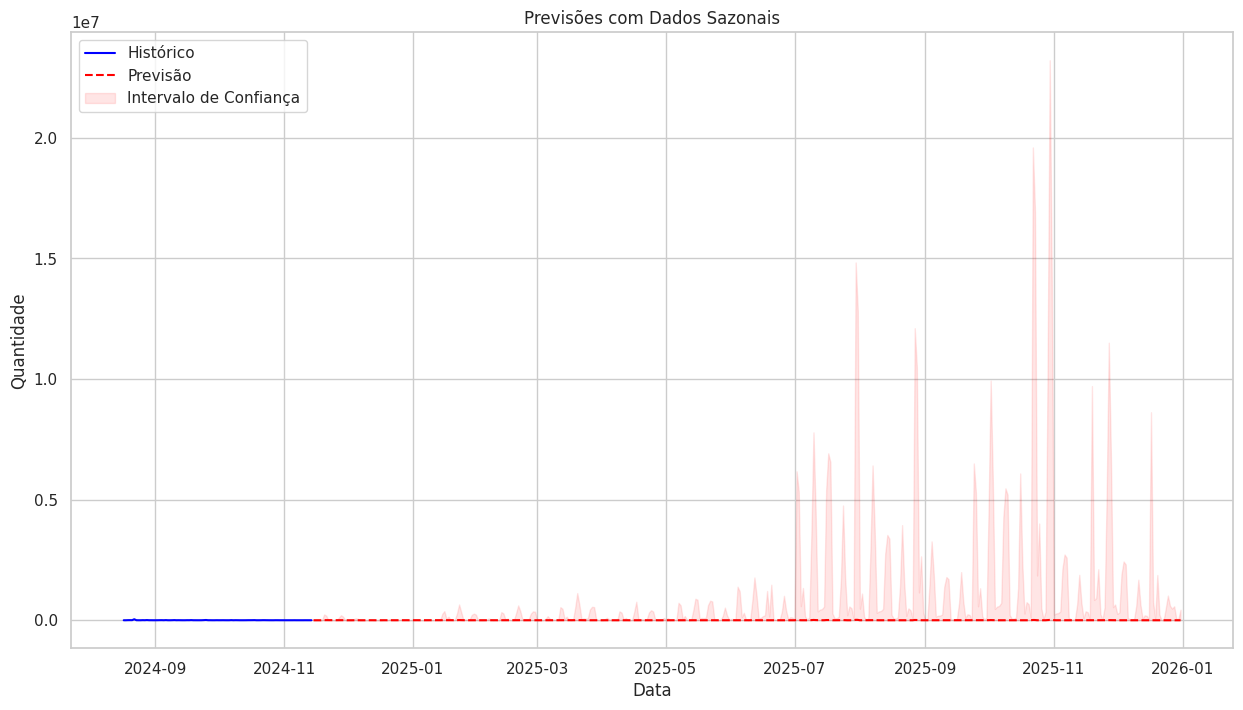


Estatísticas das Previsões:
Média: 1235.71
Máximo: 17438.89
Mínimo: 0.01


In [65]:
# 8. Visualizar resultados
plt.figure(figsize=(15, 8))
plt.plot(serie.index[-90:], serie.values[-90:], 
         label='Histórico', color='blue')
plt.plot(df_planejamento.index, forecast_mean, 
         label='Previsão', color='red', linestyle='--')
plt.fill_between(
    df_planejamento.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='red',
    alpha=0.1,
    label='Intervalo de Confiança'
)
plt.title('Previsões com Dados Sazonais')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True)
plt.show()

# 9. Mostrar algumas estatísticas das previsões
print("\nEstatísticas das Previsões:")
print(f"Média: {forecast_mean.mean():.2f}")
print(f"Máximo: {forecast_mean.max():.2f}")
print(f"Mínimo: {forecast_mean.min():.2f}")


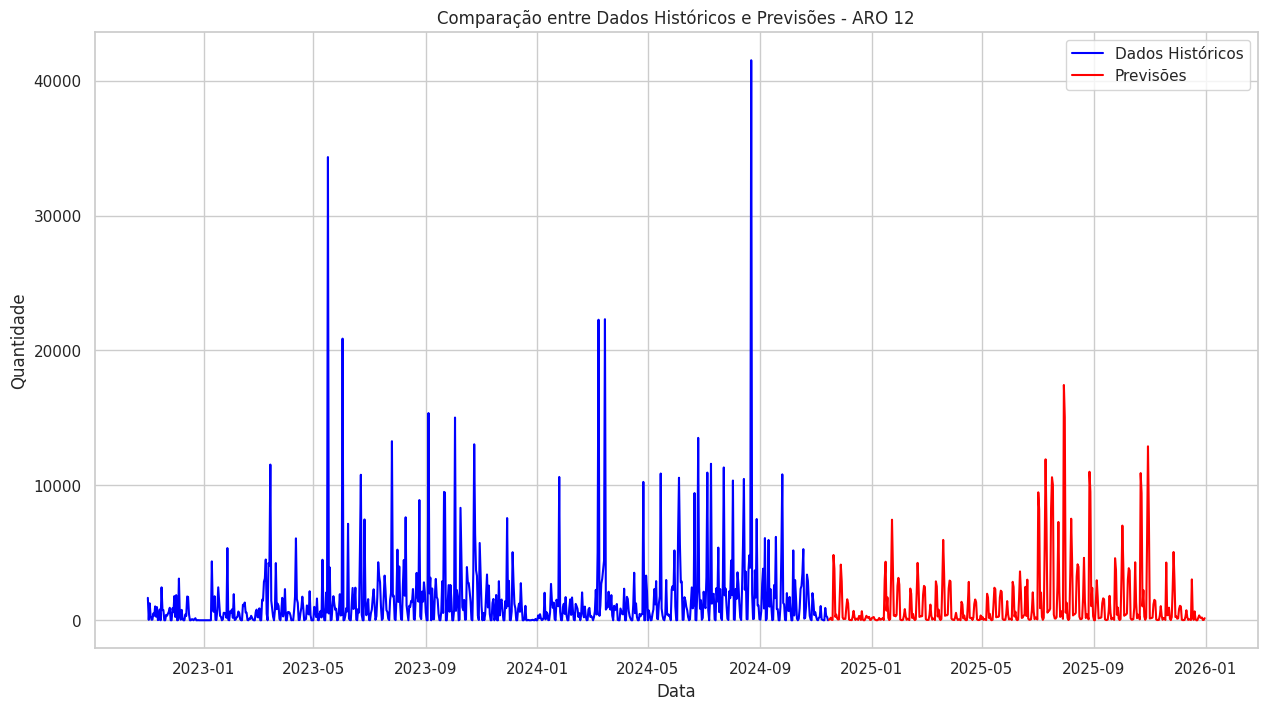

In [66]:
plt.figure(figsize=(15, 8))
plt.plot(serie_original.index, serie_original, label='Dados Históricos', color='blue')
plt.plot(df_planejamento.index, forecast_mean, label='Previsões', color='red')
plt.title(f'Comparação entre Dados Históricos e Previsões - {linha}')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.legend()
plt.grid(True)
plt.show()

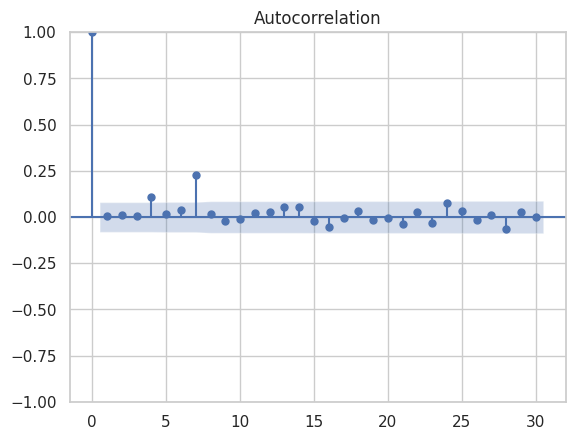

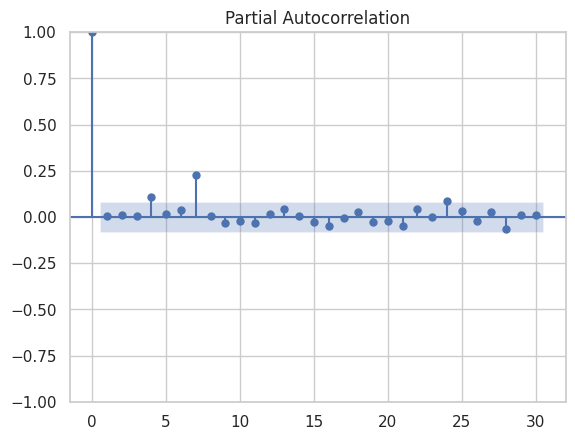

In [67]:


# Plotar ACF e PACF dos resíduos
residuos = resultado.resid
plot_acf(residuos, lags=30)
plot_pacf(residuos, lags=30)
plt.show()

### 7. SALVAR RESULTADOS ###

In [ ]:

previsoes_finais = pd.DataFrame({
    'data': df_planejamento.index,
    'previsao': forecast_mean,
    'limite_inferior': forecast_ci.iloc[:, 0],
    'limite_superior': forecast_ci.iloc[:, 1]
})

previsoes_finais.to_csv(f'../../notebooks/previsoes/previsoes_{linha.replace(" ", "_")}_tratado.csv',
                        sep=';',
                        index=False,
                        encoding='latin1')

print(f"\nPrevisões salvas em 'previsoes_{linha.replace(' ', '_')}_tratado.csv'")


Previsões salvas em 'previsoes_ARO_12_tratado.csv'


In [ ]:
import joblib

# Salvar o modelo
joblib.dump(resultado, f'../../notebooks/previsoes/modelo_sarima_{linha.replace(" ", "_")}.pkl')

# Carregar o modelo (em outro script)
modelo_carregado = joblib.load(f'modelo_sarima_{linha.replace(" ", "_")}.pkl')